# 09_Hydrological_impacts_of_climate_change.ipynb

## Performing bias correction on climate model data to perform climate change impact studies on hydrology

This notebook will guide you on how to conduct bias correction of climate model outputs that will be fed as inputs to the hydrological model `Raven` to perform climate change impact studies on hydrology. 

In this tutorial, we will be using the shapefile or GeoJSON file for watershed contours as generated in the tutorial notebooks #03 (03_Extract_geographical_watershed_properties.ipynb) and #04 (04_Delineating_watersheds.ipynb). The file can be uploaded to your workspace here and used directly in the cells below. The workflow here is a bit longer than previous ones because we integrate the climate change scenario bias-correction and the hydrological modelling that follows into a single coherent workflow. We will mainly use the GR4JCN hydrological model, but towards the end of this notebook, we also show how to use other models. 

In [1]:
'''
Import the required packages
'''
import datetime as dt
import gcsfs    # For the CMIP6 data on PanGEO
import s3fs     # For the ERA5 data on AmazonS3 / Wasabi
import xarray as xr
import intake   # Must include intake-xarray as a plugin
import zarr
import fsspec
import os
import xclim.sdba as sdba
import xclim
import json
from clisops.core import subset

## Get the CMIP6 climate data that we need, for both the reference and future period.

To begin, we need to access climate change data. We prefer the more recent CMIP6 project model scenarios, so we will use those hosted on Google Cloud Services and made available by Pangeo.
We will prepare the access point and extract minimum, maximum temperatures as well as precipitation for a 10-year period. Typically we should use a 30 year period for climate change projections but we are shortening it to 10 years to make computation time faster for this example.

In [2]:
# Here we are going to use real data. It will take a bit of time as 
# the data is huge and we need to access it and download it locally.
# It will be longer for longer time periods and larger catchments!

'''
Providing the information we want to use for our analysis.
'''
# Define climate model to use. See the complete list in the "07_Bias_correction_of_CMIP6_data.ipynb" notebook.
climate_model = 'MIROC6'

# The catchment boundaries file. Can be generated using notebook "04_Delineating watersheds", use the one for your own catchment!
basin_contour = 'input.geojson' 

# The start and end dates for the reference and future time periods.
reference_start_day = dt.datetime(1980, 12, 30)
reference_stop_day = dt.datetime(1991, 1, 2) # Notice we are using 2 days before and 2 days after the desired period of 1981-01-01 to 1990-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.
future_start_day = dt.datetime(2080, 12, 30)
future_stop_day = dt.datetime(2091, 1, 2) # Notice we are using 2 days before and 2 days after the desired period of 2081-01-01 to 2090-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.


'''
Prepare the filesystem that allows reading CMIP6 data. Data is read on the Google Cloud Services, 
which host a copy of the CMIP6 (and other) data. 
'''
fsCMIP = gcsfs.GCSFileSystem(token='anon', access='read_only')


'''
Get the catalog info from the pangeo dataset, which basically is a list of links to the various products.
'''
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")


'''
Load the files from the PanGEO catalogs, for reference and future variables of temperature and precipitation.
'''
with xr.set_options(keep_attrs=True):
    
    # Reference period (named 'historical' in CMIP6)
    query = dict(experiment_id=['historical'],table_id='day',variable_id=['tasmin', 'tasmax', 'pr'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id', 'variable_id'], **query)
    dd = col_subset.to_dataset_dict(zarr_kwargs={"consolidated":True})
    ds_reference = subset.subset_shape(dd[list(dd.keys())[0]].sel(time=slice(reference_start_day,reference_stop_day)),'input.geojson').mean({'lat','lon'}).chunk(-1)
    ds_reference=ds_reference.isel(member_id=0).drop({'member_id','height'})

    # Get the variables we need from the full dataset
    historical_pr = ds_reference['pr']
    historical_tasmin = ds_reference['tasmin']
    historical_tasmax = ds_reference['tasmax']

    # Future period
    query = dict(experiment_id=['ssp585'],table_id='day',variable_id=['tasmin', 'tasmax', 'pr'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id', 'variable_id'], **query)
    dd = col_subset.to_dataset_dict(zarr_kwargs={"consolidated":True})
    ds_future = subset.subset_shape(dd[list(dd.keys())[0]].sel(time=slice(future_start_day,future_stop_day)),'input.geojson').mean({'lat','lon'}).chunk(-1)
    ds_future = ds_future.isel(member_id=0).drop({'member_id','height'})

    # Get the variables we need from the full dataset
    future_pr = ds_future['pr']
    future_tasmin = ds_future['tasmin']
    future_tasmax = ds_future['tasmax']



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
2022-02-16 03:46:43,244 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2022-02-16 03:46:43,245 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2022-02-16 03:46:43,246 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2022-02-16 03:46:46,253 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: timed out
2022-02-16 03:46:46,254 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: timed out
2022-02-16 03:46:46,256 - google.auth.compute_engine._metadata - WARNI

/tmp/ipykernel_5951/1387737040.py:43: UserWarning: CRS definitions are similar but raster lon values must be wrapped.
  ds_reference = subset.subset_shape(dd[list(dd.keys())[0]].sel(time=slice(reference_start_day,reference_stop_day)),'input.geojson').mean({'lat','lon'}).chunk(-1)
/opt/conda/envs/birdy/lib/python3.8/site-packages/clisops/core/subset.py:528: UserWarning: Wrapping longitudes at 180 degrees.
  warnings.warn("Wrapping longitudes at 180 degrees.")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
2022-02-16 03:46:55,591 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2022-02-16 03:46:55,594 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2022-02-16 03:46:55,595 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2022-02-16 03:46:58,601 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: timed out
2022-02-16 03:46:58,603 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: timed out
2022-02-16 03:46:58,604 - google.auth.compute_engine._metadata - WARNI

/tmp/ipykernel_5951/1387737040.py:55: UserWarning: CRS definitions are similar but raster lon values must be wrapped.
  ds_future = subset.subset_shape(dd[list(dd.keys())[0]].sel(time=slice(future_start_day,future_stop_day)),'input.geojson').mean({'lat','lon'}).chunk(-1)
/opt/conda/envs/birdy/lib/python3.8/site-packages/clisops/core/subset.py:528: UserWarning: Wrapping longitudes at 180 degrees.
  warnings.warn("Wrapping longitudes at 180 degrees.")


## Now that we have the climate scenarios, we need a historical dataset or observations to perform the bias correction.
In this tutorial, we will use ERA5 realaysis data to make things easier and ensure data is available for the entire world with no missing data. If you have your own dataset, you can provide it instead, as long as it has the precipitation, maximum temperatures and minimum temperatures at the daily time step.

In [3]:
# Get the ERA5 data from the Wasabi/Amazon S3 server. 
# Will eventually be replaced by the more efficient direct call with auto-updating timesteps.
# Future code:

# catalog_name = 'https://raw.githubusercontent.com/hydrocloudservices/catalogs/main/catalogs/atmosphere.yaml'
# cat=intake.open_catalog(catalog_name)
# ds=cat.era5_hourly_reanalysis_single_levels_ts.to_dask()

# For now, let's use this method:
''' 
Configuration keys. Boilerplate, should not be changed.
'''
CLIENT_KWARGS = {'endpoint_url': 'https://s3.wasabisys.com','region_name': 'us-east-1'}
CONFIG_KWARGS = {'max_pool_connections': 100}
STORAGE_OPTIONS = {'anon': True,'client_kwargs': CLIENT_KWARGS,'config_kwargs': CONFIG_KWARGS}

'''
Prepare the filesystem and mapper that points to the data itself on the AmazonS3 directory
'''
fsERA5 = fsspec.filesystem('s3', **STORAGE_OPTIONS)
mapper = fsERA5.get_mapper('s3://era5/world/reanalysis/single-levels/zarr-temporal/2021-06-30')

'''
Get the ERA5 data (for the same reference period)
'''
# Extract the data for the region of interest only, and transform the hourly data to daily
# Also rechunk to make it faster to read.
with xr.set_options(keep_attrs=True):
    ds = xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day))
    sub=subset.subset_shape(ds,basin_contour).mean({'latitude','longitude'})
    ERA5_tmin=sub['t2m'].resample(time='1D').min().chunk(-1,-1,-1)
    ERA5_tmax=sub['t2m'].resample(time='1D').max().chunk(-1,-1,-1)
    ERA5_pr = sub['tp'].resample(time='1D').mean().chunk(-1,-1,-1)

In [6]:
# Here we need to make sure that our units are all in the correct format.
# Let's start with precipitation:
ERA5_pr = xclim.core.units.convert_units_to(ERA5_pr,'mm',context='hydro')
# The CMIP data is a rate rather than an absolute value, so let's get the absolute values:
historical_pr = xclim.core.units.rate2amount(historical_pr)
future_pr = xclim.core.units.rate2amount(future_pr)

# Now we can actually convert units in absolute terms.
historical_pr = xclim.core.units.convert_units_to(historical_pr,'mm',context='hydro')
future_pr = xclim.core.units.convert_units_to(future_pr,'mm',context='hydro')

# Now let's do temperature:
ERA5_tmin = xclim.core.units.convert_units_to(ERA5_tmin,'degC')
ERA5_tmax = xclim.core.units.convert_units_to(ERA5_tmax,'degC')
historical_tasmin = xclim.core.units.convert_units_to(historical_tasmin,'degC')
historical_tasmax = xclim.core.units.convert_units_to(historical_tasmax,'degC')
future_tasmin = xclim.core.units.convert_units_to(future_tasmin,'degC')
future_tasmax = xclim.core.units.convert_units_to(future_tasmax,'degC')

## Start the bias-correction!

Here we use the `xclim` utilities to get the data by month. See `xclim` documentation for more options! (https://xclim.readthedocs.io/en/stable/notebooks/sdba.html)

In [7]:
'''
Load the model to use for the bias correction - the `detrended quantile mapping`.
'''

# Use xclim utilities (sbda) to give information on the type of window used for the bias correction.
group_month_window = sdba.utils.Grouper("time.dayofyear", window=15)

The model is now initialized and ready to find correction factors between the reference dataset (observations) and historical dataset (climate model outputs for the same time period). The correction factors obtained are then applied to both reference and future climate outputs to correct them. This step is called the bias correction step.

In [8]:
# This is an adjusting function. It builds the tool that will perform the corrections.
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_pr, hist=historical_pr,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_precip = Adjustment.adjust(historical_pr, interp="linear")

# Apply the correction factors on the future period
corrected_fut_precip = Adjustment.adjust(future_pr, interp="linear")

# Ensure that the precipitation is non-negative, which can happen with some climate models
corrected_ref_precip[corrected_ref_precip < 0] = 0
corrected_fut_precip[corrected_fut_precip < 0] = 0
print(corrected_ref_precip)

# Train the model to find the correction factors for the maximum temperature (tasmax) data
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_tmax, hist=historical_tasmax,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_tasmax = Adjustment.adjust(historical_tasmax, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmax = Adjustment.adjust(future_tasmax, interp="linear")

# Train the model to find the correction factors for the minimum temperature (tasmin) data
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_tmin, hist=historical_tasmin,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_tasmin = Adjustment.adjust(historical_tasmin, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmin = Adjustment.adjust(future_tasmin, interp="linear")

/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(


<xarray.DataArray 'scen' (time: 3655)>
dask.array<setitem, shape=(3655,), dtype=float64, chunksize=(3655,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-12-30T12:00:00 ... 1991-01-01T12:00:00
Attributes:
    units:            mm
    history:          [2022-02-16 03:52:24] : Bias-adjusted with DetrendedQua...
    bias_adjustment:  DetrendedQuantileMapping(group=Grouper(add_dims=[], nam...


/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when u

### The corrected reference and future data are then converted to netCDF files to be used by our 'Raven' hydrological models

In [9]:
# Convert the reference corrected data into netCDF file
ref_dataset = xr.merge([
    corrected_ref_precip.to_dataset(name="pr"),
    corrected_ref_tasmax.to_dataset(name="tasmax"), 
    corrected_ref_tasmin.to_dataset(name="tasmin")
])
ref_dataset.to_netcdf("reference_dataset.nc")

# Convert the future corrected data into netCDF file
fut_dataset = xr.merge([
    corrected_fut_precip.to_dataset(name="pr"),
    corrected_fut_tasmax.to_dataset(name="tasmax"), 
    corrected_fut_tasmin.to_dataset(name="tasmin")
])
fut_dataset.to_netcdf("future_dataset.nc")

## Our data is ready. Let's do some hydrological modelling to see how the future streamflow might look like compared to the reference streamflow!

In this step, we will take the reference period climate data and run the GR4JCN hydrological model with it. We will then plot a graph to see the streamflow representative of the historical period.

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)


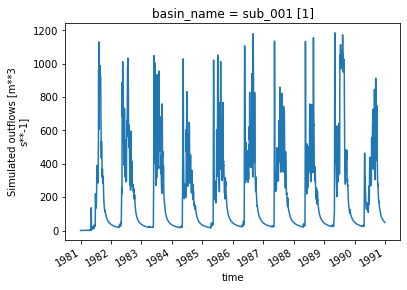

In [10]:
# Need to import the GR4JCN hydrological model instance
from ravenpy.models import GR4JCN

# Start a model instance, in this case a GR4JCN model emulator.
model = GR4JCN()

# Path to the climate data needed to run the Raven model on the reference period.
# All files in your current workspace (the "writable-workspace") can be accessed by adding the "/notebook_dir/writable-workspace/" prefix in the path.
forcing='/notebook_dir/writable-workspace/reference_dataset.nc'

# Model configuration parameters that will be used for the simulation for both the reference and future periods.
common_run_parameters = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
    tasmax={"offset": -273.15}, # Transforms that are 2-parameters of a linear equation ax + b, so temperature uses a=1.0 and b = -273.15 to bring K to degC.
    tasmin={"offset": -273.15}, # Transforms that are 2-parameters of a linear equation ax + b, so temperature uses a=1.0 and b = -273.15 to bring K to degC.
    pr={"scale": 86400.0}, # Transforms that are 2-parameters of a linear equation ax + b, so temperature uses a=86400 and b = 0 to bring mm/s to mm/d.
    rain_snow_fraction="RAINSNOW_DINGMAN", 
)

# Run the hydrological model using our forcing data from the reference period, and with the common parameters that will also be used for the future period simulation.
model(
    forcing,
    start_date=dt.datetime(1981,1,1),
    end_date=dt.datetime(1990,12,31),
    **common_run_parameters,
     )

# Now plot the results
model.hydrograph.q_sim.plot()

## Now do the same but for the future period!
We will copy the block of code from above, changing only the file path (from reference dataset to future dataset) as well as the start and end dates.

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2081-04-27
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2081-08-26
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2081-08-27
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2085-04-25
  warn(msg, category=R

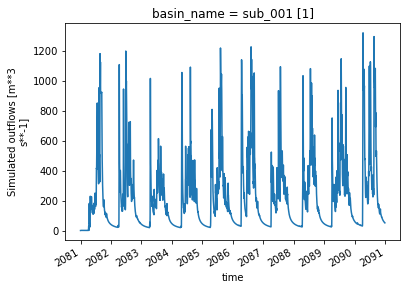

In [11]:
# Now redo the same thing but for the future period.

# Start a new model instance
model = GR4JCN()
params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947)

# Accessing the future data we just created -- notice it is now the "future_dataset.nc" instead of the "reference_dataset.nc"
forcing='/notebook_dir/writable-workspace/future_dataset.nc'

# Model configuration parameters
model(forcing,
    start_date=dt.datetime(2081,1,1), # Now running the future period!
    end_date=dt.datetime(2090,12,31),
    **common_run_parameters,   
)

# And plot the results! We can compare both figures and see the changes between both.
model.hydrograph.q_sim.plot()

## You have just generated streamflows for the reference and future periods!
We can analyze these hydrographs with many tools in PAVICS-Hydro, or export them to use elsewhere, or use them as inputs to another process!